In [1]:
import os, re, json, shutil, time, cycler, itertools
import numpy as np
from ase.io import read, write, iread
from ase.io.trajectory import Trajectory
from ase.visualize import view, external
from ase import units
from ase.geometry.analysis import Analysis

from IPython.utils.io import capture_output
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import norm, foldnorm
from tqdm import tqdm

from matplotlib import rc
from matplotlib import gridspec

from ase.calculators.cp2k import CP2K
from ase.calculators.orca import ORCA
from ase.calculators.psi4 import Psi4

from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin

from ase.optimize import LBFGS

In [104]:
def center_COM(atoms):
    """Center the COM of `atoms` in their own cell."""

    # position of box center
    c = 0.5 * atoms.get_cell().sum(axis=0) + atoms.get_celldisp().T

    # center of mass shifted to box center
    positions = atoms.get_positions() - atoms.get_center_of_mass() + c

    # update positions in place
    atoms.set_positions(positions)


def new_sim_dir(path="", prefix="simulation"):
    '''
    Looks for all non-empty enumerated directories of desired format and returns new dirname with id one greater.
    '''
    reg_dir_num = re.compile("_[0-9]{3}_")
    id_list = [int(re.findall(reg_dir_num, f.path)[0].replace('_','')) for f in os.scandir() 
               if f.is_dir() and "/simulation_" in f.path and len(os.listdir(f)) > 0]
    current = max([0] + id_list)
    
    new_dirname = "{}_{:03d}_".format(prefix, current + 1)
    print(new_dirname)
    
    return new_dirname    


def save_parameters(pars, filename="parameters.json"):
    par_rev = pars.copy()
    par_rev['atoms'] = par_rev['atoms'].get_chemical_symbols()
    
    with open(par_rev['output_dir'] + filename, 'w') as jsfile:
        json.dump(par_rev, jsfile, indent=4)


def load_energies(path):
    reg_num = re.compile("[-0-9.]+")

    times = list()
    E_tot = list()
    E_pot = list()
    E_kin = list()

    with open(path, 'r') as file:
        print("Header: {}".format(next(file)))        # dumps the header
        for line in file:
            num_data = re.findall(reg_num, line.replace("\n",""))
            for i, lst in enumerate([times, E_tot, E_pot, E_kin]):
                lst.append(float(num_data[i]))
                
    return times, E_tot, E_pot, E_kin


class MyTimer:
    def __init__(self, output_path):
        self.path = output_path
        self.data = list()
        self.stack = dict()
        
    def start(self,label):
        t0 = time.time()
        self.stack.update({label:t0})
        
    def stop(self,label,save_data=False):
        dt = time.time() - self.stack.pop(label)
        self.data.append([label, dt])
        
        if save_data is True:
            self.save_data()
            
    def stop_start(self, label='step'):
        dt = time.time() - self.stack.pop(label) if label in self.stack.keys() else 0
        self.data.append([label, dt]) if dt != 0 else None
        
        t1 = time.time()
        self.stack.update({label:t1})
    
        
    def save_data(self):
        with open(self.path, 'w') as file:
            file.write("Date and time of the simulation run:   {} \n".format(time.strftime("%A, %d %b %Y %H:%M:%S", time.gmtime()) ))
            file.write(" LABEL   TIME [s] \n")
            
            for line in self.data:
                file.write(" {}   {:.3f} s \n".format(line[0], float(line[1])))
                
                
def transform_frames(path, n_sim, ox_id=[0,3], H_id=4):
    def center_atom_pair(frame, pos1, pos2, center):
        d_center = center - (pos1 + (pos2 - pos1)/2)
        frame.translate(d_center)
        
    for i in range(n_sim):
        new_traj = Trajectory(path + 'coords_transformed_{:03d}.traj'.format(i), 'w')

        times, E_tot, E_pot, E_kin = load_energies(path + 'energies_{:03d}.log'.format(i))

        ird = iread(path + "coords_{:03d}.traj".format(i), index=':')

        for frame in ird:
            cell_center = frame.get_cell().sum(axis=0) / 2
            pos1, pos2 = frame.get_positions()[ox_id]

            center_atom_pair(frame, pos1, pos2, cell_center)
            frame.rotate(pos2 - pos1, [1,0,0], center=cell_center )   # orient oxygen pair in x-axis direction

            shared_H_pos = frame.get_positions()[H_id]
            frame.rotate((shared_H_pos - cell_center)*np.array([0,1,1]), [0,0,1], center=cell_center)   # restrict shared H movement to x-z  plane only  

            new_traj.write(frame)

        write(path + "coords_transformed_{:03d}.xyz".format(i), read(path + "coords_transformed_{:03d}.traj".format(i), index=':'), format="xyz")


def load_timings(path, n=1):
    #base_dir = "./simulation_{:03d}_{}/"
    all_times = list()

    #pth = base_dir.format(i, sw)
    times, E_tot, E_pot, E_kin = load_energies(path+'/energies_000.log')

    timings = np.zeros((n,len(times)))
    iter_times = np.zeros(n)
    n = 0
    m = 0

    with open(path+'/timings.txt', 'r') as file:
        for line in file:
            if '.' not in line:
                continue 
            dat = [x for x in line.split(' ') if len(x) > 1]
            lab, tm = str(dat[0]), float(dat[1])

            if lab == 'step':
                timings[m, n] = tm
                n += 1
            elif 'iter' in lab:
                iter_times[m] = tm
                m += 1
                n = 0

        all_times.append(np.concatenate(timings))
        print(timings.mean())
    return np.array(all_times)

def to_time(number, H=False, M=True, decimals=1):
    hours = "{:02d}h ".format(int(number/3600)) if H else ""
    minutes = "{:02d}m ".format(int((number%3600)/60)) if M else ""
    seconds = str("{:02."+str(decimals)+"f}s").format(number%60)
    
    return hours+minutes+seconds

# **Simulation**

## **Define initial structure**

In [149]:
zundel = read("./input_files/initial.pdb",format='proteindatabank')

In [150]:
L = 12.0 * np.ones(3)
zundel.set_cell(L)
center_COM(zundel)

print(zundel.get_positions())
print(zundel.get_center_of_mass())

[[5.84488069 6.76080447 6.90022558]
 [5.67888069 7.70080447 6.75722558]
 [5.85988069 6.56480447 7.84522558]
 [6.15188069 5.26080447 5.07122558]
 [6.01188069 5.93680447 5.96622558]
 [7.02988069 4.86680447 4.95822558]
 [5.47088069 4.58780447 4.92622558]]
[6. 6. 6.]


In [151]:
#view(zundel, viewer='vmd')

## **Calculator setup**

### Setup CP2K

In [152]:
os.environ['CP2K_DATA_DIR'] = "/home/mptacek/md_project"
CP2K.command = '/home/mptacek/software/cp2k_shell.ssmp --shell' 

In [153]:
# load CP2K input file
with open("./input_files/zundel_cp2k.inp") as f_inp:
    inp_cp2k = f_inp.read()

In [154]:
calculator = CP2K(
    inp=inp_cp2k,
    directory='calculator',
    stress_tensor=False,
    cutoff=None,
    basis_set_file=None,
    potential_file=None,
    poisson_solver=None,
    max_scf=None,
    xc=None,
    basis_set=None,
    pseudo_potential=None,
)
pp = 'CP2K'

### Setup ORCA

In [10]:
ORCA.command = '/home/mptacek/software/orca_5_0_2_linux_x86-64_openmpi411/orca PREFIX.inp > PREFIX.out'

orca_pars = dict(label='orcacalc',
                 charge=1,
                 mult=1,
                 orcasimpleinput='HF def2-TZVP',
                 #orcasimpleinput='B3LYP cc-PVTZ',
                 orcablocks='%maxcore 2000 %pal nprocs 4 end',
                )

pp = orca_pars

calculator = ORCA(label=pp['label'], charge=pp['charge'], mult=pp['mult'], orcasimpleinput=pp['orcasimpleinput'],
                  orcablocks=pp['orcablocks'],
                 )

### Setup Psi4

In [5]:
psi4_pars = dict(method='hf',
                 #method='hf',
                 #method='m06',
                 #basis='6-311g_d_p_',
                 #basis='aug-cc-pVTZ',
                 basis='cc-PVTZ',
                 charge=1,
                 multiplicity=1,
                 memory='6GB',
                 num_threads=4,
                 label='psi4-calc',
                )

pp = psi4_pars
calculator = Psi4(atoms=zundel, method=pp['method'], basis=pp['basis'], charge=pp['charge'],
                  multiplicity=pp['multiplicity'], memory=pp['memory'], num_threads=pp['num_threads'],
                  label=pp['label'],
                 )


  Memory set to   5.588 GiB by Python driver.
  Threads set to 4 by Python driver.


In [155]:
zun = zundel.copy()
zun.set_calculator(calculator)
zun.get_potential_energy()

-224.42873821661

In [156]:
opt = LBFGS(zun)
opt.run(fmax=0.01)

E = zun.get_potential_energy()

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 14:09:48     -224.428738*       0.7979
LBFGS:    1 14:09:48     -224.436222*       0.2852
LBFGS:    2 14:09:49     -224.440962*       0.2460
LBFGS:    3 14:09:49     -224.450690*       0.2471
LBFGS:    4 14:09:49     -224.452241*       0.1961
LBFGS:    5 14:09:49     -224.454902*       0.1652
LBFGS:    6 14:09:49     -224.457697*       0.1585
LBFGS:    7 14:09:49     -224.459140*       0.1714
LBFGS:    8 14:09:49     -224.461625*       0.1632
LBFGS:    9 14:09:49     -224.464320*       0.1642
LBFGS:   10 14:09:49     -224.465819*       0.0958
LBFGS:   11 14:09:49     -224.466455*       0.0696
LBFGS:   12 14:09:49     -224.466943*       0.0652
LBFGS:   13 14:09:49     -224.467254*       0.0650
LBFGS:   14 14:09:49     -224.467569*       0.0614
LBFGS:   15 14:09:50     -224.467951*       0.0935
LBFGS:   16 14:09:50     -224.468419*       0.0913
LBFGS:   17 14:09:50     -224.4688

In [8]:
zun.get_total_energy()

-4148.307267169012

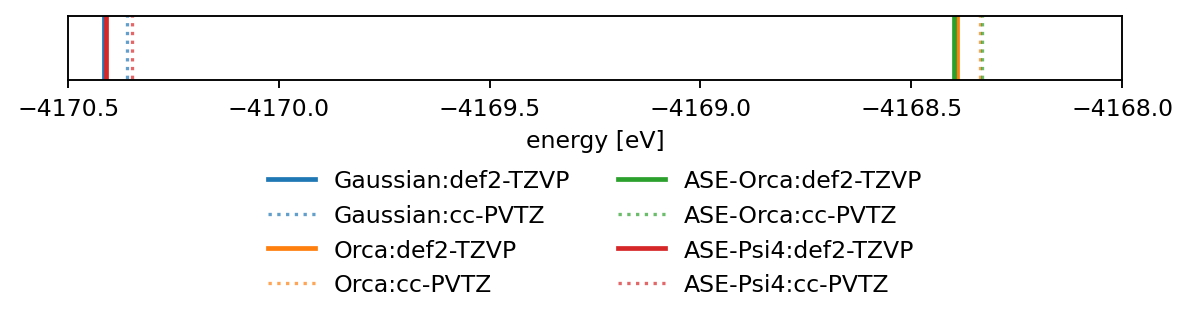

In [30]:
plt.figure(figsize=(8,0.5), dpi=170, facecolor='w')
labels = list()
data = list()
i = 0

for sw, dct in zip(['Gaussian', 'Orca', 'ASE-Orca','ASE-Psi4'], [gaussian_opt, orca_opt, ase_orca_opt, ase_psi4_opt]):
    i +=1
    par = {'alpha':1, 'linewidth':2}
    for key, val in dct.items():
        sc = plt.plot([val, val], [-10, 10], label='{}:{}'.format(sw, key), **par)
        par.update({'color':sc[0].get_color(), 'alpha':0.7, 'linestyle':'dotted', 'linewidth':1.4})
        
plt.yticks([])
plt.ylim(-6,10)
plt.xlim(-4170.5, -4168)
plt.xlabel('energy [eV]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -3.7), ncol=2, frameon=False)
#plt.plot([-4175, -4165], [0,0], color='gray', linewidth=0.5)

In [12]:
gaussian_B3LYP_opt = {'def2-TZVP':-153.2599425*units.Hartree, 'cc-PVTZ':-153.2579534*units.Hartree}
gaussian_HF_opt = {'def2-TZVP':-152.448807*units.Hartree, 'cc-PVTZ':-152.4474975*units.Hartree}
orca_B3LYP_opt = {'def2-TZVP':-153.185558840579*units.Hartree, 'cc-PVTZ':-153.183525600636*units.Hartree}
orca_HF_opt = {'def2-TZVP':-152.448804707483*units.Hartree, 'cc-PVTZ':-152.447495037799*units.Hartree}

ase_B3LYP_orca_opt = {'def2-TZVP':-4168.399060245498, 'cc-PVTZ':-4168.332964306133}
ase_B3LYP_psi4_opt = {'def2-TZVP':-4170.409984063548, 'cc-PVTZ':-4170.348402570653}
ase_HF_orca_opt = {'def2-TZVP':-4148.343312586606, 'cc-PVTZ':-4148.30768484958}
ase_HF_psi4_opt = {'cc-PVTZ':-4148.307267169012, }

gaussian_DFTB_opt = {'DFTB':-8.21692541132*units.Hartree, }
ase_DFTB_cp2k_opt = {'DFTB':}

29 {'label': 'ORCA,HF', 'color': array([0., 0., 0., 1.])}
30 {'label': 'PSI4,HF', 'color': array([0.    , 0.    , 0.8667, 1.    ])}
38 {'label': 'ORCA,B3LYP', 'color': array([1. , 0.6, 0. , 1. ])}
23 {'label': 'PSI4,B3LYP', 'color': array([0.8, 0.8, 0.8, 1. ])}


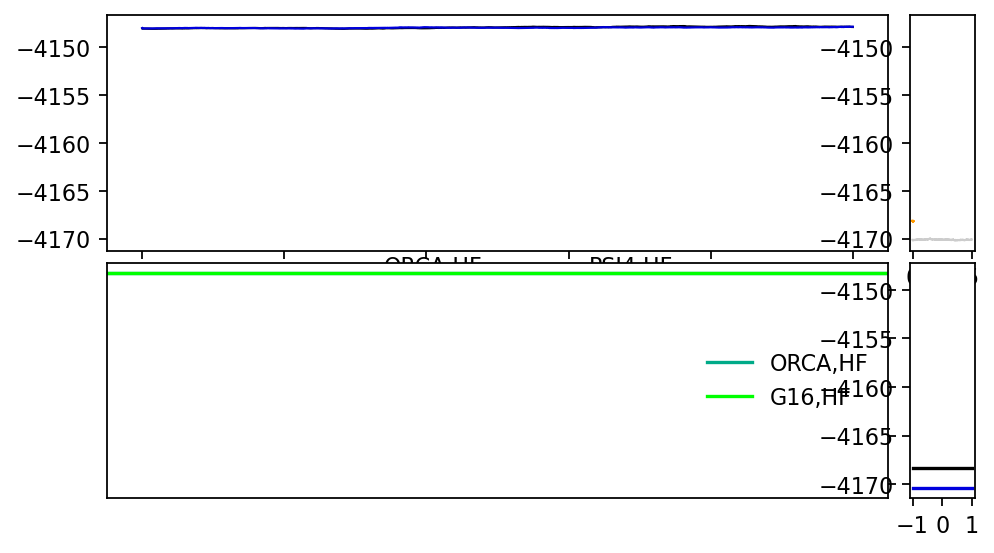

In [18]:
indices = [[29, 30], [38, 23]]
labels = [['ORCA,HF','PSI4,HF'], ['ORCA,B3LYP','PSI4,B3LYP']]
opt_data = [{'ORCA,HF':orca_HF_opt, 'G16,HF':gaussian_HF_opt}, {'ORCA,B3LYP':orca_B3LYP_opt, 'G16,B3LYP':gaussian_B3LYP_opt}]
basis = 'cc-PVTZ'

n = 6
color = plt.cm.nipy_spectral(np.linspace(0, 1,n))
cycl = itertools.cycle(color)


num_ids = len(indices)
fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=160, facecolor='w')
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[12,1], figure=fig) 

ax = [plt.subplot(gs[0]), plt.subplot(gs[2])] 
ax += [plt.subplot(gs[1], sharey=ax[0]), plt.subplot(gs[3], sharey=ax[1])]

#iterlab = ['({})'.format(k) for k in range(1, num_ids+1)] if labels is None else ['({})\n{}'.format(k,l) for k,l in zip(range(1, num_ids+1), labels)]
colors = list()

for l, (labs, idx, opts) in enumerate(zip(labels, indices, opt_data)):
    for num, index in enumerate(idx):
        dname = [d for d in os.listdir("./") if "simulation_{:03d}_".format(index) in d][0]
        max_num = max([int(f.split('.')[0].split('_')[1]) for f in os.listdir("./{}/".format(dname)) if 'energies' in f])

        all_energies = list()
        pars = {'label':labs[num], 'color':next(cycl)}

        for i in range(int(max_num) + 1):
            with capture_output() as captured:
                times, E_tot, E_pot, E_kin = load_energies(dname + "/energies_{:03d}.log".format(i))
            num_times = len(times)
            all_energies.append(E_tot)
            print(index, pars)
            line = ax[0].plot(times, E_tot, linewidth=1, **pars)
            pars.update({'color':line[0].get_color(), 'label':""})

        colors.append(line[0].get_color())

    for lab, dct in opts.items():
        E_opt = dct[basis] 
        ax[2*l+1].plot([-1,1], [E_opt]*2, color=next(cycl), label=lab)

ax[1].set_xlim(-1,1)
ax[1].yaxis.tick_right()
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
ax[1].tick_params(axis='x', length=0)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=4)
ax[1].legend(loc='center right', bbox_to_anchor=(1, 0.5), frameon=False, ncol=1)
plt.show()

29 {'label': 'ORCA,HF (6.5s)', 'color': array([0.18995, 0.07176, 0.23217, 1.     ])}
30 {'label': 'PSI4,HF (1.1s)', 'color': array([0.15844, 0.73551, 0.92305, 1.     ])}
38 {'label': 'ORCA,B3LYP (7.6s)', 'color': array([0.33517, 0.98234, 0.46325, 1.     ])}
23 {'label': 'PSI,B3LYP (3.6s)', 'color': array([0.98   , 0.73   , 0.22161, 1.     ])}


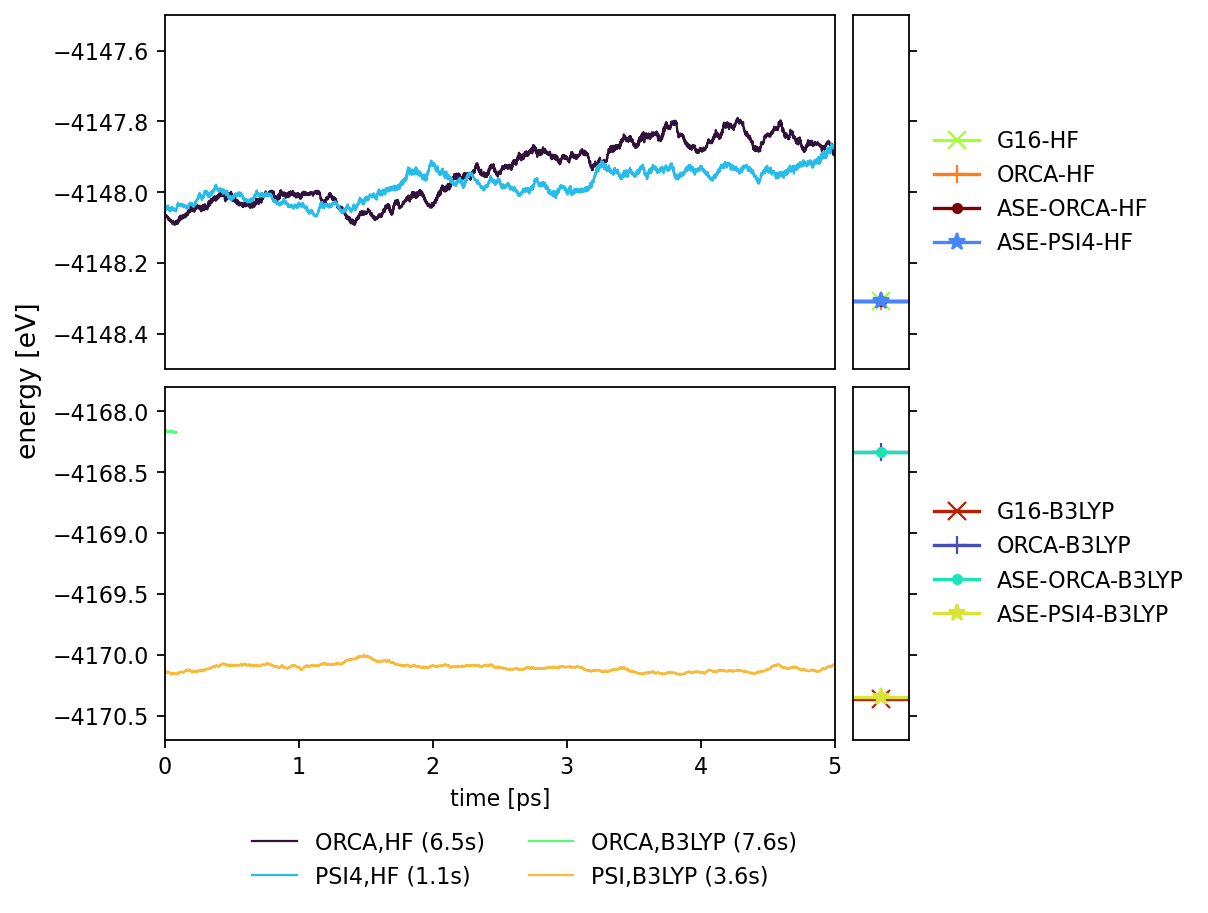

In [137]:
t1 = [29, 30]
t2 = [38, 23]
l1 = ['ORCA,HF','PSI4,HF']
l2 = ['ORCA,B3LYP','PSI,B3LYP']

d2 = {'G16-B3LYP':gaussian_B3LYP_opt,'ORCA-B3LYP':orca_B3LYP_opt,
      'ASE-ORCA-B3LYP':ase_B3LYP_orca_opt, 
      'ASE-PSI4-B3LYP':ase_B3LYP_psi4_opt, 
     }
d1 = {'G16-HF':gaussian_HF_opt, 'ORCA-HF':orca_HF_opt, 'ASE-ORCA-HF':ase_HF_orca_opt, 'ASE-PSI4-HF':ase_HF_psi4_opt}
    
n = 13
color = plt.cm.turbo(np.linspace(0, 1,n))
cycl = itertools.cycle(color)
mrkrs = itertools.cycle(('x', '+', '.', '*')) 

num_ids = len(indices)
fig, ax = plt.subplots(num=None, figsize=(6,6), dpi=160, facecolor='w')
gs = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[12,1], figure=fig) 

ax = [plt.subplot(gs[0]), plt.subplot(gs[2])] 
ax += [plt.subplot(gs[1], sharey=ax[0]), plt.subplot(gs[3], sharey=ax[1])]

lines = list()

for num, index in enumerate(t1):
    dname = [d for d in os.listdir("./") if "simulation_{:03d}_".format(index) in d][0]
    max_num = max([int(f.split('.')[0].split('_')[1]) for f in os.listdir("./{}/".format(dname)) if 'energies' in f])

    all_energies = list()
    pars = {'label':l1[num]+'.', 'color':next(cycl)}
    next(cycl)
    next(cycl)

    for i in range(int(max_num) + 1):
        with capture_output() as captured:
            times, E_tot, E_pot, E_kin = load_energies(dname + "/energies_{:03d}.log".format(i))
            timings = load_timings(dname)
            
        pars.update({'label':pars['label'].replace('.',' ({})'.format(to_time(np.median(timings), M=False)))})
        num_times = len(times)
        all_energies.append(E_tot)
        print(index, pars)
        line = ax[0].plot(times, E_tot, linewidth=1, **pars)
        pars.update({'color':line[0].get_color(), 'label':""})
        lines.append(line[0])

    colors.append(line[0].get_color())

for lab, dct in d1.items():
    E_opt = dct[basis] 
    ax[2].plot([-2,0,2], [E_opt]*3, color=next(cycl), label=lab, marker=next(mrkrs), markersize=8)
    next(cycl)
    next(cycl)

for num, index in enumerate(t2):
    dname = [d for d in os.listdir("./") if "simulation_{:03d}_".format(index) in d][0]
    max_num = max([int(f.split('.')[0].split('_')[1]) for f in os.listdir("./{}/".format(dname)) if 'energies' in f])

    all_energies = list()
    pars = {'label':l2[num]+'.', 'color':next(cycl)}
    next(cycl)
    next(cycl)

    for i in range(int(max_num) + 1):
        with capture_output() as captured:
            times, E_tot, E_pot, E_kin = load_energies(dname + "/energies_{:03d}.log".format(i))
            timings = load_timings(dname)
            
        pars.update({'label':pars['label'].replace('.',' ({})'.format(to_time(np.median(timings), M=False)))})
        num_times = len(times)
        all_energies.append(E_tot)
        print(index, pars)
        line = ax[1].plot(times, E_tot, linewidth=1, **pars)
        pars.update({'color':line[0].get_color(), 'label':""})
        lines.append(line[0])

    colors.append(line[0].get_color())

for lab, dct in d2.items():
    E_opt = dct[basis] 
    ax[3].plot([-2,0,2], [E_opt]*3, color=next(cycl), label=lab, marker=next(mrkrs), markersize=8)
    next(cycl)
    next(cycl)
    
ax[0].set_xlim(0,5)
ax[1].set_xlim(0,5)
ax[2].set_xlim(-1,1)
ax[3].set_xlim(-1,1)
ax[2].yaxis.tick_right()
ax[3].yaxis.tick_right()
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[2].get_yticklabels(), visible=False)
plt.setp(ax[3].get_yticklabels(), visible=False)
plt.setp(ax[2].get_xticklabels(), visible=False)
plt.setp(ax[3].get_xticklabels(), visible=False)
ax[0].tick_params(axis='x', length=0)
ax[2].tick_params(axis='x', length=0)
ax[3].tick_params(axis='x', length=0)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

ax[0].set_ylim(-4148.5, -4147.5)
ax[1].set_ylim(-4170.7, -4167.8)

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=4)
#ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=4)
ax[2].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False, ncol=1)
ax[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False, ncol=1)
fig.legend(handles=lines, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
fig.supylabel('energy [eV]', x=-0.03)
ax[1].set_xlabel('time [ps]')
plt.show()

29 {'label': 'ORCA,HF (6.5s)', 'color': array([0.18995, 0.07176, 0.23217, 1.     ])}
30 {'label': 'PSI4,HF (1.1s)', 'color': array([0.15844, 0.73551, 0.92305, 1.     ])}
38 {'label': 'ORCA,B3LYP (7.6s)', 'color': array([0.33517, 0.98234, 0.46325, 1.     ])}
23 {'label': 'PSI,B3LYP (3.6s)', 'color': array([0.98   , 0.73   , 0.22161, 1.     ])}


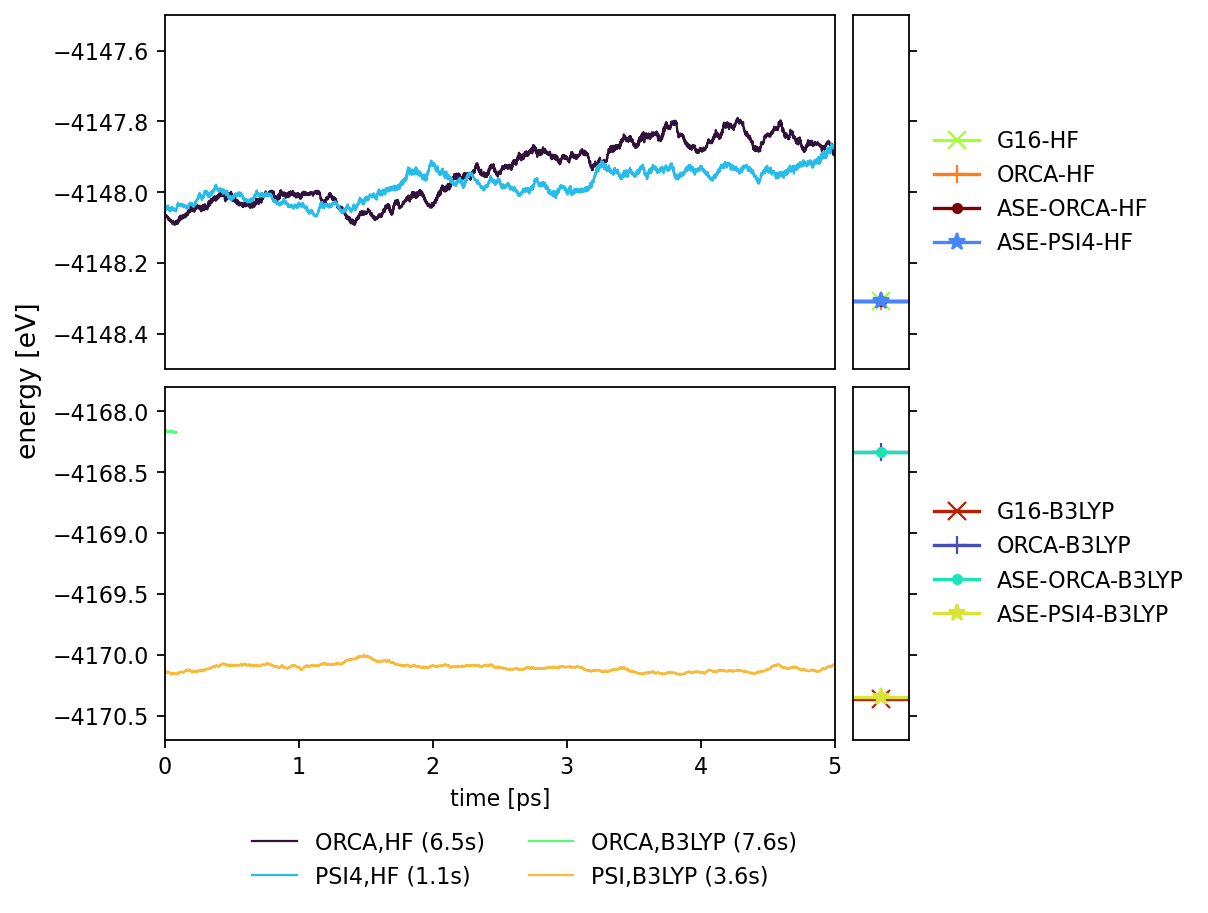

In [137]:
t1 = [29, 30]
t2 = [38, 23]
l1 = ['ORCA,HF','PSI4,HF']
l2 = ['ORCA,B3LYP','PSI,B3LYP']

d2 = {'G16-B3LYP':gaussian_B3LYP_opt,'ORCA-B3LYP':orca_B3LYP_opt,
      'ASE-ORCA-B3LYP':ase_B3LYP_orca_opt, 
      'ASE-PSI4-B3LYP':ase_B3LYP_psi4_opt, 
     }
d1 = {'G16-HF':gaussian_HF_opt, 'ORCA-HF':orca_HF_opt, 'ASE-ORCA-HF':ase_HF_orca_opt, 'ASE-PSI4-HF':ase_HF_psi4_opt}
d3 = {'G16-DFTB'}

n = 13
color = plt.cm.turbo(np.linspace(0, 1,n))
cycl = itertools.cycle(color)
mrkrs = itertools.cycle(('x', '+', '.', '*')) 

num_ids = len(indices)
fig, ax = plt.subplots(num=None, figsize=(6,6), dpi=160, facecolor='w')
gs = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[12,1], figure=fig) 

ax = [plt.subplot(gs[0]), plt.subplot(gs[2])] 
ax += [plt.subplot(gs[1], sharey=ax[0]), plt.subplot(gs[3], sharey=ax[1])]

lines = list()

for num, index in enumerate(t1):
    dname = [d for d in os.listdir("./") if "simulation_{:03d}_".format(index) in d][0]
    max_num = max([int(f.split('.')[0].split('_')[1]) for f in os.listdir("./{}/".format(dname)) if 'energies' in f])

    all_energies = list()
    pars = {'label':l1[num]+'.', 'color':next(cycl)}
    next(cycl)
    next(cycl)

    for i in range(int(max_num) + 1):
        with capture_output() as captured:
            times, E_tot, E_pot, E_kin = load_energies(dname + "/energies_{:03d}.log".format(i))
            timings = load_timings(dname)
            
        pars.update({'label':pars['label'].replace('.',' ({})'.format(to_time(np.median(timings), M=False)))})
        num_times = len(times)
        all_energies.append(E_tot)
        print(index, pars)
        line = ax[0].plot(times, E_tot, linewidth=1, **pars)
        pars.update({'color':line[0].get_color(), 'label':""})
        lines.append(line[0])

    colors.append(line[0].get_color())

for lab, dct in d1.items():
    E_opt = dct[basis] 
    ax[2].plot([-2,0,2], [E_opt]*3, color=next(cycl), label=lab, marker=next(mrkrs), markersize=8)
    next(cycl)
    next(cycl)

for num, index in enumerate(t2):
    dname = [d for d in os.listdir("./") if "simulation_{:03d}_".format(index) in d][0]
    max_num = max([int(f.split('.')[0].split('_')[1]) for f in os.listdir("./{}/".format(dname)) if 'energies' in f])

    all_energies = list()
    pars = {'label':l2[num]+'.', 'color':next(cycl)}
    next(cycl)
    next(cycl)

    for i in range(int(max_num) + 1):
        with capture_output() as captured:
            times, E_tot, E_pot, E_kin = load_energies(dname + "/energies_{:03d}.log".format(i))
            timings = load_timings(dname)
            
        pars.update({'label':pars['label'].replace('.',' ({})'.format(to_time(np.median(timings), M=False)))})
        num_times = len(times)
        all_energies.append(E_tot)
        print(index, pars)
        line = ax[1].plot(times, E_tot, linewidth=1, **pars)
        pars.update({'color':line[0].get_color(), 'label':""})
        lines.append(line[0])

    colors.append(line[0].get_color())

for lab, dct in d2.items():
    E_opt = dct[basis] 
    ax[3].plot([-2,0,2], [E_opt]*3, color=next(cycl), label=lab, marker=next(mrkrs), markersize=8)
    next(cycl)
    next(cycl)
    
ax[0].set_xlim(0,5)
ax[1].set_xlim(0,5)
ax[2].set_xlim(-1,1)
ax[3].set_xlim(-1,1)
ax[2].yaxis.tick_right()
ax[3].yaxis.tick_right()
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[2].get_yticklabels(), visible=False)
plt.setp(ax[3].get_yticklabels(), visible=False)
plt.setp(ax[2].get_xticklabels(), visible=False)
plt.setp(ax[3].get_xticklabels(), visible=False)
ax[0].tick_params(axis='x', length=0)
ax[2].tick_params(axis='x', length=0)
ax[3].tick_params(axis='x', length=0)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

ax[0].set_ylim(-4148.5, -4147.5)
ax[1].set_ylim(-4170.7, -4167.8)

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=4)
#ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=4)
ax[2].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False, ncol=1)
ax[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False, ncol=1)
fig.legend(handles=lines, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
fig.supylabel('energy [eV]', x=-0.03)
ax[1].set_xlabel('time [ps]')
plt.show()

In [108]:
aa = {'jj':'hjh'}
aa.update({'jj':aa['jj'].replace('j','X')})
aa

{'jj': 'hXh'}

In [34]:
def plot_energies(indices, labels, opt_data, basis='cc-PVTZ'):  
    n = 8
    color = plt.cm.nipy_spectral(np.linspace(0, 1,n))
    cycl = itertools.cycle(color)


    num_ids = len(indices)
    fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=160, facecolor='w')
    gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[12,1], figure=fig) 
    
    ax = [plt.subplot(gs[0])] 
    ax += [plt.subplot(gs[1], sharey=ax[0])]

    #iterlab = ['({})'.format(k) for k in range(1, num_ids+1)] if labels is None else ['({})\n{}'.format(k,l) for k,l in zip(range(1, num_ids+1), labels)]
    colors = list()
    
    for num, index in enumerate(indices):
        dname = [d for d in os.listdir("./") if "simulation_{:03d}_".format(index) in d][0]
        max_num = max([int(f.split('.')[0].split('_')[1]) for f in os.listdir("./{}/".format(dname)) if 'energies' in f])
        
        all_energies = list()
        pars = {'label':labels[num], 'color':next(cycl)}
        
        for i in range(int(max_num) + 1):
            with capture_output() as captured:
                times, E_tot, E_pot, E_kin = load_energies(dname + "/energies_{:03d}.log".format(i))
            num_times = len(times)
            all_energies.append(E_tot)
            print(index, pars)
            line = ax[0].plot(times, E_tot, linewidth=1, **pars)
            pars.update({'color':line[0].get_color(), 'label':""})
            
        colors.append(line[0].get_color())
        
    for lab, dct in opt_data.items():
        E_opt = dct[basis] 
        ax[1].plot([-1,1], [E_opt]*2, color=next(cycl), label=lab)
        
    ax[0].set_xlim(0,5)
    ax[1].set_xlim(-1,1)
    ax[1].yaxis.tick_right()
    plt.setp(ax[1].get_yticklabels(), visible=False)
    plt.setp(ax[1].get_xticklabels(), visible=False)
    ax[1].tick_params(axis='x', length=0)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    
    ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=4)
    ax[1].legend(loc='center right', bbox_to_anchor=(5.5, 0.5), frameon=False, ncol=1)
    plt.show()
    

29 {'label': 'ORCA,HF', 'color': array([0., 0., 0., 1.])}
30 {'label': 'ORCA,B3LYP', 'color': array([0.09411176, 0.        , 0.65492941, 1.        ])}
38 {'label': 'PSI4,HF', 'color': array([0.        , 0.56340784, 0.8667    , 1.        ])}
23 {'label': 'PSI,B3LYP', 'color': array([0.        , 0.63008039, 0.24050784, 1.        ])}


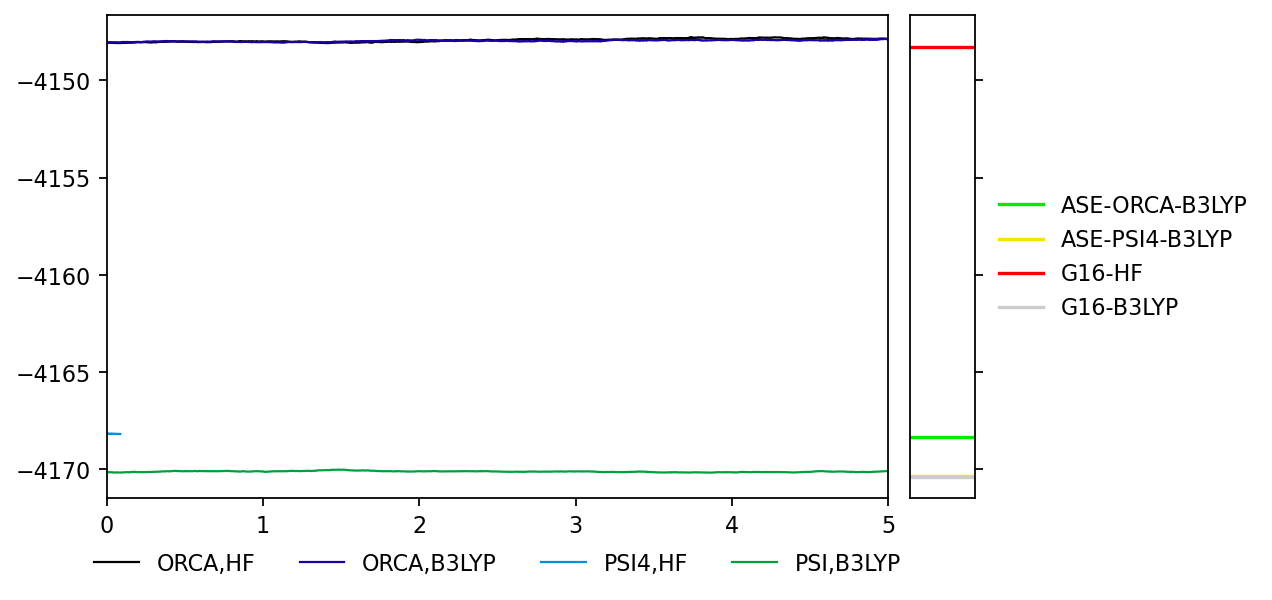

In [35]:
plot_energies([29, 30, 38, 23], ['ORCA,HF','ORCA,B3LYP','PSI4,HF','PSI,B3LYP'], 
              {'ASE-ORCA-B3LYP':ase_B3LYP_orca_opt, 'ASE-PSI4-B3LYP':ase_B3LYP_psi4_opt, 
               'G16-HF':gaussian_HF_opt, 'G16-B3LYP':gaussian_B3LYP_opt, })